<a href="https://colab.research.google.com/github/mrazimi99/deep-packet/blob/main/DeepPacket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install scapy

In [ ]:
from pathlib import Path
import os
import os.path
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from scapy.compat import raw
from scapy.layers.inet import IP, UDP
from scapy.layers.l2 import Ether
from scapy.packet import Padding
from scapy.utils import rdpcap
from scipy import sparse
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from random import sample
import matplotlib.pyplot as plt
import math

from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler

import time
from datetime import timedelta
from datetime import datetime
import pickle

from utils import should_omit_packet, PREFIX_TO_APP_ID, PREFIX_TO_TRAFFIC_ID

In [5]:
def remove_ether_header(packet):
    if Ether in packet:
        return packet[Ether].payload

    return packet


def mask_ip(packet):
    if IP in packet:
        packet[IP].src = '0.0.0.0'
        packet[IP].dst = '0.0.0.0'

    return packet


def pad_udp(packet):
    if UDP in packet:
        # get layers after udp
        layer_after = packet[UDP].payload.copy()

        # build a padding layer
        pad = Padding()
        pad.load = '\x00' * 12

        layer_before = packet.copy()
        layer_before[UDP].remove_payload()
        packet = layer_before / pad / layer_after

        return packet

    return packet


def packet_to_sparse_array(packet, max_length=1500):
    arr = np.frombuffer(raw(packet), dtype=np.uint8)[0: max_length] / 255
    if len(arr) < max_length:
        pad_width = max_length - len(arr)
        arr = np.pad(arr, pad_width=(0, pad_width), constant_values=0)

    arr = sparse.csr_matrix(arr)
    return arr


def transform_packet(packet):
    if should_omit_packet(packet):
        return None

    packet = remove_ether_header(packet)
    packet = pad_udp(packet)
    packet = mask_ip(packet)

    arr = packet_to_sparse_array(packet)

    return arr

pcaps = 'drive/MyDrive/deep-packet/Pcaps/'
cache = 'drive/MyDrive/deep-packet/dataset.pickle'
dataset = []

if not os.path.isfile(cache):
    for path in os.listdir(pcaps):
        print('Processing ' + path)
        cnt = 0
        for i, packet in enumerate(rdpcap(pcaps + path)):
            #####
            if cnt > 500:
                break
            #####
            arr = transform_packet(packet)
            if arr is not None:
                cnt += 1
                # get labels for app identification
                prefix = path.split('.')[0].lower()
                app_label = PREFIX_TO_APP_ID.get(prefix)
                traffic_label = PREFIX_TO_TRAFFIC_ID.get(prefix)
                row = {
                    'app_label': app_label,
                    'traffic_label': traffic_label,
                    'feature': arr.todense().tolist()[0]
                }
                dataset.append(row)
    
    with open(cache, 'wb') as f:
        pickle.dump(dataset, f)
else:
    with open(cache, 'rb') as f:
        dataset = pickle.load(f)

Processing AIMchat2.pcapng
Processing scpDown5.pcap
Processing sftp_up_2a.pcap
Processing email1b.pcap
Processing facebook_audio2a.pcap
Processing vpn_vimeo_B.pcap
Processing skype_video1a.pcap
Processing hangouts_audio4.pcapng
Processing skype_chat1a.pcap
Processing youtube2.pcap
Processing ftps_up_2b.pcap
Processing scpDown1.pcap
Processing hangouts_audio3.pcapng
Processing torYoutube2.pcap
Processing ftps_up_2a.pcap


In [6]:
traffic_labels = [row['traffic_label'] for row in dataset]
app_labels = [row['app_label'] for row in dataset]
traffic_classes = set(traffic_labels)
app_classes = set(app_labels)

traffic_train_all, traffic_test_all = train_test_split(dataset, test_size=0.2, random_state=42, stratify=traffic_labels)
app_train_all, app_test_all = train_test_split(dataset, test_size=0.2, random_state=42, stratify=app_labels)

In [7]:
undersample = RandomUnderSampler(sampling_strategy='majority')
traffic_features = [elem['feature'] for elem in traffic_train_all]
train_traffic_labels = [elem['traffic_label'] for elem in traffic_train_all]
traffic_train, traffic_y = undersample.fit_resample(traffic_features, train_traffic_labels)

undersample = RandomUnderSampler(sampling_strategy='majority')
app_features = [elem['feature'] for elem in app_train_all]
train_app_labels = [elem['app_label'] for elem in app_train_all]
app_train, app_y = undersample.fit_resample(app_features, train_app_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [8]:
traffic_train_final = [{'feature': torch.from_numpy(np.array(f.tolist(), dtype=np.float32)), 'label': l} for f, l in zip(traffic_train, traffic_y)]
app_train_final = [{'feature': torch.from_numpy(np.array(f.tolist(), dtype=np.float32)), 'label': l} for f, l in zip(app_train, app_y)]

traffic_test_final = [{'feature': torch.from_numpy(np.array(elem['feature'], dtype=np.float32)), 'label': elem['traffic_label']} for elem in traffic_test_all]
app_test_final = [{'feature': torch.from_numpy(np.array(elem['feature'], dtype=np.float32)), 'label': elem['app_label']} for elem in app_test_all]

In [9]:
batch_size = 64
num_workers = 2
traffic_train_loader = torch.utils.data.DataLoader(traffic_train_final, batch_size=batch_size, num_workers=num_workers)
app_train_loader = torch.utils.data.DataLoader(app_train_final, batch_size=batch_size, num_workers=num_workers)
traffic_test_loader = torch.utils.data.DataLoader(traffic_test_final, batch_size=batch_size, num_workers=num_workers)
app_test_loader = torch.utils.data.DataLoader(app_test_final, batch_size=batch_size, num_workers=num_workers)

In [10]:
class Model(nn.Module):
    def __init__(self, input_num, middle_layers, output_num, act):
        super(Model, self).__init__()
        self.layers = nn.ModuleList()
        self.acts = []

        self.layers.append(nn.Linear(input_num, middle_layers[0]))
        self.acts.append(act)

        for i in range(len(middle_layers) - 1):
            self.layers.append(nn.Linear(middle_layers[i], middle_layers[i + 1]))
            self.acts.append(act)

        self.layers.append(nn.Linear(middle_layers[-1], output_num))

    def forward(self, x):

        x = x.view(x.size(0), -1)

        for i in range(len(self.layers) - 1):
            x = self.layers[i](x)
            x = self.acts[i](x)

        x = self.layers[-1](x)
        return x

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [12]:
def fit(model, train_loader, device, criterion, optimizer, num_epochs=10):
    total_time = 0.
    loss_per_epoch = {e + 1 : 0 for e in range(num_epochs)}

    for epoch in range(num_epochs):
        train_loss = 0.
        d1 = datetime.now()

        for elem in train_loader:
            byte_array = elem['feature'].to(device)
            labels = elem['label'].to(device)

            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()

            # Forward pass to get output/logits
            outputs = model(byte_array)

            # Calculate Loss: softmax --> cross entropy loss
            loss = criterion(outputs, labels)

            # Getting gradients w.r.t. parameters
            loss.backward()

            # Updating parameters
            optimizer.step()
            train_loss += loss.item()

        average_loss = train_loss / len(train_loader)
        d2 = datetime.now()
        delta = d2 - d1
        seconds = float(delta.total_seconds())
        total_time += seconds
        loss_per_epoch[epoch + 1] = average_loss
        print('epoch %d, train_loss: %.3f, time elapsed: %s seconds' % (epoch + 1, average_loss, seconds))

    if math.isnan(max(loss_per_epoch.values())):
        print('Could not plot for nan losses.')
    else:
        plt.plot(list(loss_per_epoch.keys()), list(loss_per_epoch.values()))
        plt.title('Avreage Loss Per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Aerage Loss')
        plt.xlim(1, num_epochs + 1)
        plt.ylim(0, max(loss_per_epoch.values()) + 1)
        plt.show()

    print('total training time: %.3f minutes' % (total_time / 60))

In [13]:
def test_model_accuracy(model, test_loader, classes):
    # Calculate Accuracy         
    correct = 0.
    total = 0.
    correct_predicted = {id : 0 for id in range(len(classes))}
    num_of_labels = {id : 0 for id in range(len(classes))}

    # Iterate through test dataset
    with torch.no_grad():
      for elem in test_loader:
        byte_array = elem['feature'].to(device)
        labels = elem['label']
        outputs = model(byte_array)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        for p, l in zip(predicted, labels):
            num_of_labels[l.item()] += 1

            if p == l:
                correct_predicted[p.to('cpu').item()] += 1

        correct += (predicted.to('cpu') == labels).sum().item()

    accuracy = 100 * correct / total
    print('Accuracy: {}%'.format(accuracy))
    return [x / y if y else 0 for x, y in zip(correct_predicted.values(), num_of_labels.values())]

In [14]:
def analyse(model, train_loader, test_loader, classes):
    print('Train ', end='')
    train_accs = test_model_accuracy(model, train_loader, classes)
    print('Test ', end='')
    test_accs = test_model_accuracy(model, test_loader, classes)
    plt.figure(figsize=(30, 9), dpi= 80, facecolor='w', edgecolor='k')
    plt.bar([i - 0.1 for i in range(len(classes))], train_accs, width=0.2, label='Train')
    plt.bar([i + 0.1 for i in range(len(classes))], test_accs, width=0.2, label='Test')
    plt.legend()
    plt.xlim(-0.2, len(classes))
    plt.xticks(list(range(len(classes))), classes, rotation='vertical')
    plt.title('Comparision Between Test and Train Accuracies')
    plt.xlabel('Category')
    plt.ylabel('Accuracy')
    plt.show()

In [15]:
input_vector = 1500
output_len = max(traffic_classes) + 1
model = Model(input_vector, [200, 200] , 10, F.relu)
model = model.to(device)

learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [16]:
print(traffic_classes)

{0, 1, 2, 3, 5, 9}


epoch 1, train_loss: 2.167, time elapsed: 0.631906 seconds
epoch 2, train_loss: 1.783, time elapsed: 0.447686 seconds
epoch 3, train_loss: 1.601, time elapsed: 0.423357 seconds
epoch 4, train_loss: 1.454, time elapsed: 0.437914 seconds
epoch 5, train_loss: 1.363, time elapsed: 0.428701 seconds
epoch 6, train_loss: 1.321, time elapsed: 0.428379 seconds
epoch 7, train_loss: 1.291, time elapsed: 0.4422 seconds
epoch 8, train_loss: 1.259, time elapsed: 0.432447 seconds
epoch 9, train_loss: 1.226, time elapsed: 0.433186 seconds
epoch 10, train_loss: 1.194, time elapsed: 3.484497 seconds
epoch 11, train_loss: 1.162, time elapsed: 3.673189 seconds
epoch 12, train_loss: 1.130, time elapsed: 0.461285 seconds
epoch 13, train_loss: 1.099, time elapsed: 0.44502 seconds
epoch 14, train_loss: 1.068, time elapsed: 0.44784 seconds
epoch 15, train_loss: 1.038, time elapsed: 0.448435 seconds
epoch 16, train_loss: 1.008, time elapsed: 0.43505 seconds
epoch 17, train_loss: 0.979, time elapsed: 0.447521 se

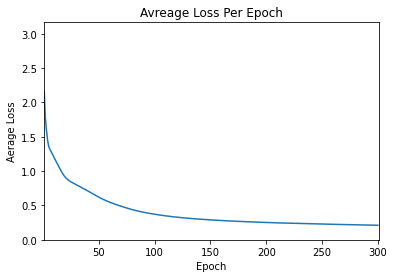

total training time: 2.353 minutes


In [17]:
fit(model, traffic_train_loader, device, criterion, optimizer, num_epochs=300)

{0, 1, 2, 3, 5, 9}
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Train Accuracy: 83.36118405347338%
Test Accuracy: 69.91028295376121%


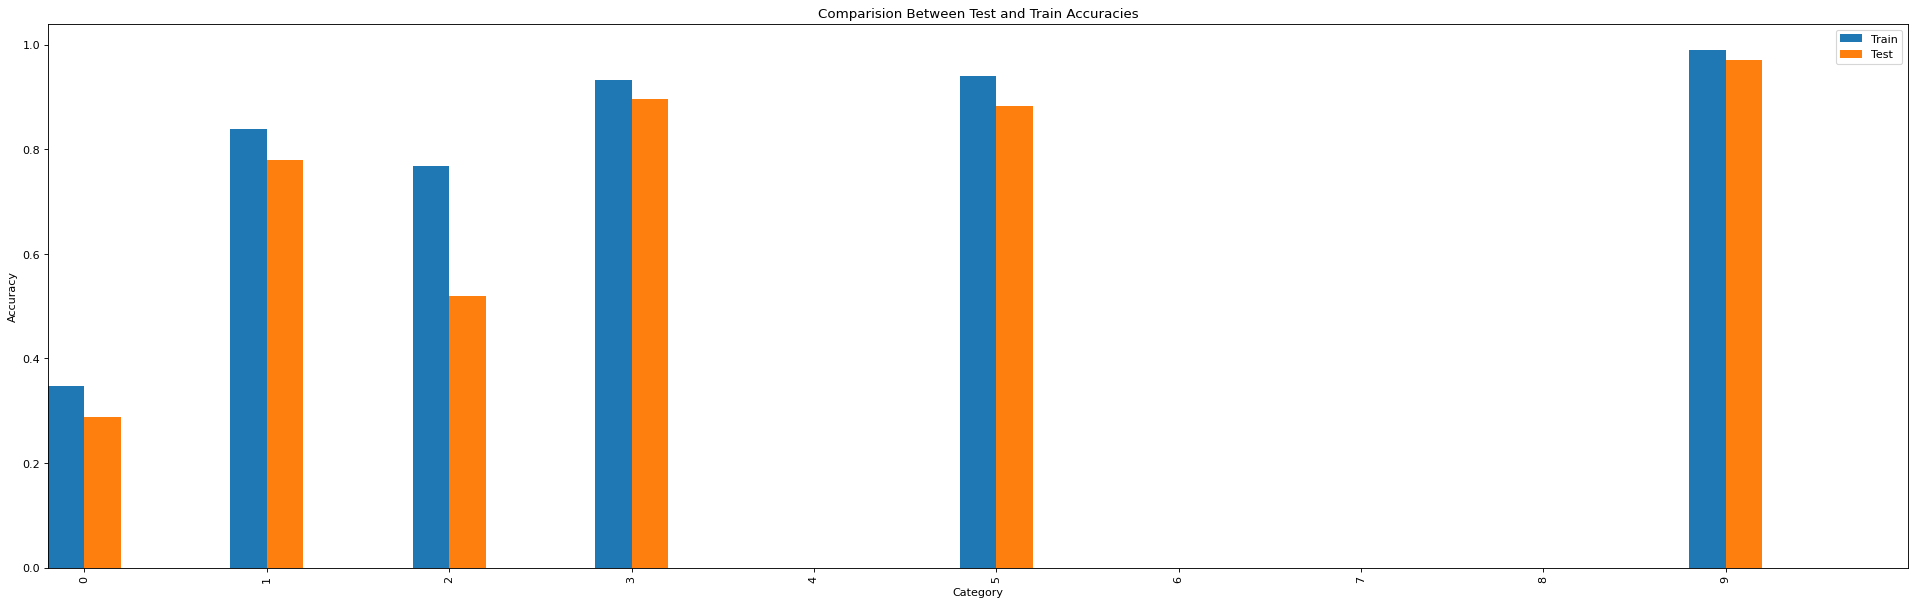

In [18]:
print(traffic_classes)
classes = [i for i in range(max(traffic_classes) + 1)]
print(classes)
analyse(model, traffic_train_loader, traffic_test_loader, classes)